In [ ]:
DATASET = 'SST5'
# DATASET = 'SST2'
BSZ = 128
EPOCH = 8
# MODEL = 'bert'
# MODEL = 'roberta'
# MODEL = 'xlnet'
# MODEL = 'distilbert'
MODEL = 'edm-roberta'

KOKONOTEST = 'D_' + DATASET + '_M_' + MODEL + '_B_' + str(BSZ) + '_E_' + str(EPOCH)
print(KOKONOTEST)

### View GPU

In [2]:
!nvidia-smi

Mon Jun 19 14:36:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:20:00.0 Off |                  N/A |
| 35%   55C    P8    31W / 200W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Some Installation

In [3]:
!pip install --upgrade pip
!pip install -q transformers==4.28.1
!pip install git+https://github.com/huggingface/transformers
!pip install fastai==1.0.58
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install SentencePiece
    
!pip list | grep -E 'transformers|tokenizers'

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-hjhy1l_b
  ERROR: Error [Errno 2] No such file or directory: 'git': 'git' while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?
Looking in links: https://download.pytorch.org/whl/torch_stable.html
tokenizers                  0.13.3
transformers                4.28.1


### Import Libraries

In [4]:
import fastai
import transformers
print('fastai version: %s' %(fastai.__version__))
print('transformers version: %s' %(transformers.__version__))

fastai version: 1.0.58
transformers version: 4.28.1


In [5]:
device = 'cuda'
import numpy as np
import pandas as pd
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig

In [6]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

In [7]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu vars

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True # speed up with gpu
        torch.backends.cudnn.benchmark = False

### Set Path

In [8]:
# import sys
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
ROOT_PATH = '/home/temp_230612'

In [10]:
def checkpath(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [11]:
# for dirname, _, filenames in os.walk('/content/drive/My Drive/LAB/kge_sentiment_anlysis'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [12]:
#  # tokenizer version
# Version = 'T_v_1.3.3'

# root_folder = os.path.abspath(os.path.join('/content/drive/My Drive/07_research_main/lab_10', Version))

# tokenizer_folder = os.path.abspath(os.path.join(root_folder, 'tokenizer'))

In [13]:
 # model version
Version = 'M_v_8.0.0'

root_folder = os.path.abspath(os.path.join(ROOT_PATH, Version))

model_folder = os.path.abspath(os.path.join(root_folder, 'model'))
checkpath(model_folder)

### Set Arguments

In [14]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig)
}

In [15]:
# Data selection

if DATASET == 'SST5':
    dataset = 'SST5'
    DATA_ROOT = Path(os.path.join(ROOT_PATH, 'finetune_dataset/kge_sentiment_analysis'))
    train_cols = 'Phrase'
    label_cols = 'Sentiment'
    classification_head = 5
elif DATASET == 'SST2':
    dataset = 'SST2'
    DATA_ROOT = Path(os.path.join(ROOT_PATH, 'finetune_dataset/IMDB_MovieReviews'))
    train_cols = 'review'
    label_cols = 'sentiment'
    classification_head = 2


# Parameters

lr = 1e-5
bsz = BSZ
epoch = EPOCH

# model_name = 'bsz2048_DEM-RoBERTa.pkl'

seed = 42
use_fp16 = False
BOOM = 4

# Model selection

if MODEL == 'bert':
    model_type = 'bert'
    pretrained_model_name='bert-base-uncased'
    pretrained_tokenizer_name = pretrained_model_name
    EDM = False
elif MODEL == 'roberta':
    model_type = 'roberta'
    pretrained_model_name = 'roberta-large'
    pretrained_tokenizer_name = pretrained_model_name
    EDM = False
elif MODEL == 'xlnet':
    model_type = 'xlnet'
    pretrained_model_name = 'xlnet-base-cased'
    pretrained_tokenizer_name = pretrained_model_name
    EDM = False
elif MODEL == 'distilbert':
    model_type = 'distilbert'
    pretrained_model_name = 'distilbert-base-uncased'
    pretrained_tokenizer_name = pretrained_model_name
    EDM = False
elif MODEL == 'edm-roberta':
    model_type = 'roberta'
    pretrained_model_name = 'roberta-large'
    pretrained_tokenizer_name = pretrained_model_name#tokenizer_folder
    EDM = True

# model_type = 'xlm'
# pretrained_model_name = 'xlm-clm-enfr-1024'
# pretrained_tokenizer_name = pretrained_model_name
# EDM = False

In [16]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

### Dataset Import

In [17]:
seed_all(seed)

In [18]:
if(dataset == 'SST5'):
  train = pd.read_csv(DATA_ROOT / 'train.tsv.zip', sep="\t")
  test = pd.read_csv(DATA_ROOT / 'test.tsv.zip', sep='\t')

In [19]:
if(dataset == 'SST2'):
  from sklearn.model_selection import train_test_split
  df = pd.read_csv(DATA_ROOT / 'IMDB_Dataset.csv.zip')
  df['Sentiment'] = df['sentiment'].replace(['negative', 'positive'], [0, 1])
  train, test = train_test_split(df, test_size=0.5, random_state=seed)

In [20]:
print(train.shape, test.shape)
train.head()

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


### Data pre-processing

In [21]:
class TransformersBaseTokenizer(BaseTokenizer):
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type='bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.model_max_length
        self.model_type = model_type

    def __call__(self, *args, **kwargs):
        return self
    
    def tokenizer(self, t:str) -> List[str]:
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] + [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

- bert:       [CLS] + tokens + [SEP] + padding

- roberta:    [CLS] + prefix_space + tokens + [SEP] + padding

- distilbert: [CLS] + tokens + [SEP] + padding

- xlnet:      padding + tokens + [SEP] + [CLS]


In [22]:
# # from transformers import RobertaTokenizerFast
# from transformers import RobertaTokenizer

# MAX_LEN = 128
# # Create the tokenizer from a trained one
# # transformer_tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)
# transformer_tokenizer = RobertaTokenizer.from_pretrained(tokenizer_folder)#, max_len=MAX_LEN)

In [23]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_tokenizer_name)
transformer_tokenizer.model_max_length = 128#512

transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [24]:
transformer_tokenizer

RobertaTokenizer(name_or_path='roberta-large', vocab_size=50265, model_max_length=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)}, clean_up_tokenization_spaces=True)

#### Custom Numericallizer

In [25]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

#### Custom Processor

In [26]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]


#### Settings up the Databunch

In [27]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [28]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
# print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
# print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [29]:
databunch = (TextList.from_df(train, cols=train_cols, processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= label_cols)
             .add_test(test)
             .databunch(bs=bsz, pad_first=pad_first, pad_idx=pad_idx))

In [30]:
# print('[CLS] token :', transformer_tokenizer.cls_token)
# print('[SEP] token :', transformer_tokenizer.sep_token)
# print('[PAD] token :', transformer_tokenizer.pad_token)
# databunch.show_batch()

In [31]:
# print('[CLS] id: ', transformer_tokenizer.cls_token_id)
# print('[SEP] id: ', transformer_tokenizer.sep_token_id)
# print('[PAD] id: ', pad_idx)
# test_one_batch = databunch.one_batch()[0]
# print('Batch shape: ', test_one_batch.shape)
# print(test_one_batch)

### Import roBerta + Boom

In [32]:
import math
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

# from ...activations import ACT2FN, gelu
from transformers.activations import ACT2FN, gelu
# from ...modeling_outputs import (
#     BaseModelOutputWithPastAndCrossAttentions,
#     BaseModelOutputWithPoolingAndCrossAttentions,
#     CausalLMOutputWithCrossAttentions,
#     MaskedLMOutput,
#     MultipleChoiceModelOutput,
#     QuestionAnsweringModelOutput,
#     SequenceClassifierOutput,
#     TokenClassifierOutput,
# )
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    MaskedLMOutput,
    MultipleChoiceModelOutput,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutput,
    TokenClassifierOutput,
)
# from ...modeling_utils import PreTrainedModel
from transformers.modeling_utils import PreTrainedModel
# from ...pytorch_utils import apply_chunking_to_forward, find_pruneable_heads_and_indices, prune_linear_layer
from transformers.pytorch_utils import apply_chunking_to_forward, find_pruneable_heads_and_indices, prune_linear_layer
# from ...utils import (
#     add_code_sample_docstrings,
#     add_start_docstrings,
#     add_start_docstrings_to_model_forward,
#     logging,
#     replace_return_docstrings,
# )
from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
# from .configuration_roberta import RobertaConfig
from transformers.models.roberta.configuration_roberta import RobertaConfig

logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "roberta-base"
_CONFIG_FOR_DOC = "RobertaConfig"

ROBERTA_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "roberta-base",
    "roberta-large",
    "roberta-large-mnli",
    "distilroberta-base",
    "roberta-base-openai-detector",
    "roberta-large-openai-detector",
    # See all RoBERTa models at https://huggingface.co/models?filter=roberta
]

ROBERTA_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `({0})`):
            Indices of input sequence tokens in the vocabulary.

            Indices can be obtained using [`AutoTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.FloatTensor` of shape `({0})`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        token_type_ids (`torch.LongTensor` of shape `({0})`, *optional*):
            Segment token indices to indicate first and second portions of the inputs. Indices are selected in `[0,1]`:

            - 0 corresponds to a *sentence A* token,
            - 1 corresponds to a *sentence B* token.
            This parameter can only be used when the model is initialized with `type_vocab_size` parameter with value
            >= 2. All the value in this tensor should be always < type_vocab_size.

            [What are token type IDs?](../glossary#token-type-ids)
        position_ids (`torch.LongTensor` of shape `({0})`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.max_position_embeddings - 1]`.

            [What are position IDs?](../glossary#position-ids)
        head_mask (`torch.FloatTensor` of shape `(num_heads,)` or `(num_layers, num_heads)`, *optional*):
            Mask to nullify selected heads of the self-attention modules. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        inputs_embeds (`torch.FloatTensor` of shape `({0}, hidden_size)`, *optional*):
            Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation. This
            is useful if you want more control over how to convert `input_ids` indices into associated vectors than the
            model's internal embedding lookup matrix.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

In [33]:
from transformers.models.roberta.modeling_roberta import (
    RobertaAttention, 
    RobertaPreTrainedModel, 
    RobertaPooler, 
    RobertaEmbeddings, 
    RobertaClassificationHead
    )

In [34]:
from torch import Tensor

In [35]:
class GELU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(1.702 * x)

In [36]:
class Boom_Layer(nn.Module):
     def __init__(self, in_features: int, out_features: int, dropout=0.1, shortcut: bool = True, device=None, dtype=None) -> None:
         factory_kwargs = {'device': device, 'dtype': dtype}
         super(Boom_Layer, self).__init__()

         self.linear1 = nn.Linear(in_features, out_features)
         self.dropout = nn.Dropout(dropout) if dropout else None
         if not shortcut:
             self.linear2 = nn.Linear(out_features, in_features)
         self.shortcut = shortcut
         self.act = GELU()
 
     def forward(self, input: Tensor) -> Tensor:
         x = self.act(self.linear1(input))
         if self.dropout: x = self.dropout(x)
         if self.shortcut:
             ninp = input.shape[-1]
             x = torch.narrow(x, -1, 0, x.shape[-1] // ninp * ninp)
             x = x.view(*x.shape[:-1], x.shape[-1] // ninp, ninp)
             z = x.sum(dim=-2)
         else:
             z = self.linear2(x)
 
         return z

In [37]:
class RobertaIntermediateAndBoom(nn.Module):
    def __init__(self, config):
        super().__init__()
        # self.dense_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        # if isinstance(config.hidden_act, str):
        #     self.intermediate_act_fn = ACT2FN[config.hidden_act]
        # else:
        #     self.intermediate_act_fn = config.hidden_act

        # self.dense_2 = nn.Linear(config.intermediate_size, config.hidden_size)

        self.boom = Boom_Layer(config.hidden_size, config.intermediate_size)

        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # hidden_states = self.dense_1(input_tensor)
        # hidden_states = self.intermediate_act_fn(hidden_states)

        # hidden_states = self.dense_2(hidden_states)

        hidden_states = self.boom(input_tensor)

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)

        return hidden_states

In [38]:
class ModifiedRobertaLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = RobertaAttention(config)
        self.is_decoder = config.is_decoder
        self.add_cross_attention = config.add_cross_attention
        if self.add_cross_attention:
            if not self.is_decoder:
                raise ValueError(f"{self} should be used as a decoder model if cross attention is added")
            self.crossattention = RobertaAttention(config, position_embedding_type="absolute")
        # self.intermediate = RobertaIntermediate(config)#####
        # self.output = RobertaOutput(config)#####
        
        self.intermediateandboom = RobertaIntermediateAndBoom(config)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        attention_output = self_attention_outputs[0]

        # if decoder, the last output is tuple of self-attn cache
        if self.is_decoder:
            outputs = self_attention_outputs[1:-1]
            present_key_value = self_attention_outputs[-1]
        else:
            outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        cross_attn_present_key_value = None
        if self.is_decoder and encoder_hidden_states is not None:
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with cross-attention layers"
                    " by setting `config.add_cross_attention=True`"
                )

            # cross_attn cached key/values tuple is at positions 3,4 of past_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            cross_attention_outputs = self.crossattention(
                attention_output,
                attention_mask,
                head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                cross_attn_past_key_value,
                output_attentions,
            )
            attention_output = cross_attention_outputs[0]
            outputs = outputs + cross_attention_outputs[1:-1]  # add cross attentions if we output attention weights

            # add cross-attn cache to positions 3,4 of present_key_value tuple
            cross_attn_present_key_value = cross_attention_outputs[-1]
            present_key_value = present_key_value + cross_attn_present_key_value

        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )
        outputs = (layer_output,) + outputs

        # if decoder, return the attn key/values as the last output
        if self.is_decoder:
            outputs = outputs + (present_key_value,)

        return outputs

    def feed_forward_chunk(self, attention_output):
        # print(attention_output.shape)
        # intermediate_output = self.intermediate(attention_output)
        # print(intermediate_output.shape)
        # layer_output = self.output(intermediate_output, attention_output)
        # print(layer_output.shape)

        layer_output = self.intermediateandboom(attention_output)

        return layer_output

In [39]:
class ModifiedRobertaEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([ModifiedRobertaLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = False,
        output_hidden_states: Optional[bool] = False,
        return_dict: Optional[bool] = True,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, past_key_value, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )

In [40]:
class ModifiedRobertaModel(RobertaPreTrainedModel):
    """

    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in *Attention is
    all you need*_ by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz
    Kaiser and Illia Polosukhin.

    To behave as an decoder the model needs to be initialized with the `is_decoder` argument of the configuration set
    to `True`. To be used in a Seq2Seq model, the model needs to initialized with both `is_decoder` argument and
    `add_cross_attention` set to `True`; an `encoder_hidden_states` is then expected as an input to the forward pass.

    .. _*Attention is all you need*: https://arxiv.org/abs/1706.03762

    """

    _keys_to_ignore_on_load_missing = [r"position_ids"]

    # Copied from transformers.models.bert.modeling_bert.BertModel.__init__ with Bert->Roberta
    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = RobertaEmbeddings(config)
        self.encoder = ModifiedRobertaEncoder(config)

        self.pooler = RobertaPooler(config) if add_pooling_layer else None

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    @add_start_docstrings_to_model_forward(ROBERTA_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=BaseModelOutputWithPoolingAndCrossAttentions,
        config_class=_CONFIG_FOR_DOC,
    )
    # Copied from transformers.models.bert.modeling_bert.BertModel.forward
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPoolingAndCrossAttentions]:
        r"""
        encoder_hidden_states  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (`tuple(tuple(torch.FloatTensor))` of length `config.n_layers` with each tuple having 4 tensors of shape `(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.

            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        batch_size, seq_length = input_shape
        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

        if token_type_ids is None:
            if hasattr(self.embeddings, "token_type_ids"):
                buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )

In [41]:
class ModifiedRobertaForSequenceClassification(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.roberta = ModifiedRobertaModel(config, add_pooling_layer=False)
        self.classifier = RobertaClassificationHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    @add_start_docstrings_to_model_forward(ROBERTA_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        checkpoint="cardiffnlp/twitter-roberta-base-emotion",
        output_type=SequenceClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
        expected_output="'optimism'",
        expected_loss=0.08,
    )
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

### Define Model

In [42]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = classification_head

# print(config)

In [43]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel, self).__init__()
        self.transformer = transformer_model

    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=pad_idx).type(input_ids.type())
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]
        return logits

In [44]:
model = ModifiedRobertaForSequenceClassification.from_pretrained("roberta-large", config=config)

Some weights of the model checkpoint at roberta-large were not used when initializing ModifiedRobertaForSequenceClassification: ['roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.15.output.LayerNorm.bias', 'roberta.encoder.layer.18.intermediate.dense.weight', 'roberta.encoder.layer.7.output.LayerNorm.bias', 'roberta.encoder.layer.17.intermediate.dense.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.dense.bias', 'roberta.encoder.layer.3.intermediate.dense.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.9.intermediate.dense.bias', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.dense.weight', 'roberta.encoder.layer.14.output.LayerNorm.weight', 'roberta.encoder.layer.23.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'lm_head.bias', 'roberta.encoder.layer.14.output

In [45]:
for param in model.roberta.embeddings.parameters():
    param.requires_grad = False

for i in range(len(model.roberta.encoder.layer)):
    for param in model.roberta.encoder.layer[i].attention.parameters():
        param.requires_grad = False

In [46]:
custom_transformer_model = CustomTransformerModel(transformer_model=model)

In [47]:
# transformer_model = RobertaForSequenceClassification.from_pretrained(model_folder, config=config)

# custom_transformer_model = CustomTransformerModel(transformer_model=transformer_model)

### Learner: Optimizer & Metric

In [48]:
CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, custom_transformer_model,
                  opt_func = CustomAdamW,
                  metrics=[accuracy, error_rate])

learner.callbacks.append(ShowGraph(learner))

if use_fp16: learner = learner.to_fp16()

In [49]:
print(learner.model)

CustomTransformerModel(
  (transformer): ModifiedRobertaForSequenceClassification(
    (roberta): ModifiedRobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 1024, padding_idx=1)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): ModifiedRobertaEncoder(
        (layer): ModuleList(
          (0): ModifiedRobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (outp

#### Discriminative Fine-tuning and Gradual unfreezing (Optional)

In [50]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [79, 1024]           51,471,360 False     
______________________________________________________________________
Embedding            [79, 1024]           526,336    False     
______________________________________________________________________
Embedding            [79, 1024]           1,024      False     
______________________________________________________________________
LayerNorm            [79, 1024]           2,048      False     
______________________________________________________________________
Dropout              [79, 1024]           0          False     
______________________________________________________________________
Linear               [79, 1024]           1,049,600  False     
______________________________________________________________________
Linear               [79, 1024]           1,049,600  False     
_______________________________________

### Start training

In [51]:
seed_all(seed)

In [52]:
# learner.fit(epochs=epoch, lr=lr)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 3.02E-06


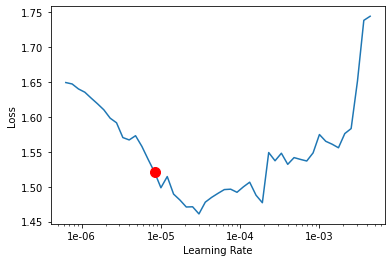

In [53]:
learner.lr_find()
learner.recorder.plot(skip_end=10, suggestion=True)

In [54]:
# learner.fit_one_cycle(20, max_lr=1e-6, moms=(0.8, 0.9))

In [55]:
# learner.fit_one_cycle(1, max_lr=lr, moms=(0.8, 0.9))

In [56]:
# learner.fit_one_cycle(1, max_lr=lr, moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.273920,1.827401,0.179867,0.820133,04:11
1,1.270185,1.709528,0.179803,0.820197,04:22
2,1.254244,1.636182,0.179867,0.820133,03:39
3,1.158866,1.622757,0.179867,0.820133,03:53
4,1.210116,1.608252,0.179867,0.820133,04:18
5,1.166190,1.581574,0.179867,0.820133,03:55
6,1.252347,1.611894,0.179867,0.820133,04:13
7,1.222821,1.589905,0.179867,0.820133,04:08
8,1.255711,1.617590,0.179867,0.820133,04:02
9,1.228167,1.546841,0.179867,0.820133,04:10


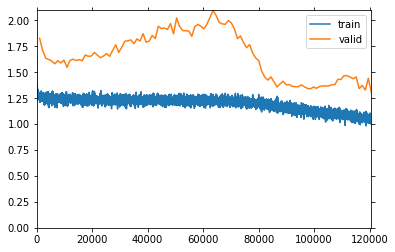

In [57]:
learner.fit(epochs=110, lr=1e-6)

In [58]:
# learner.fit(epochs=20, lr=1e-6)

In [59]:
# learner.fit(epochs=20, lr=1e-6)

### Evaluation

In [60]:
learner.predict('This movie is the worst one so far')

(Category 0, tensor(0), tensor([0.4233, 0.4169, 0.0896, 0.0572, 0.0130]))

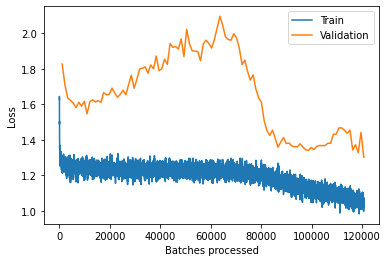

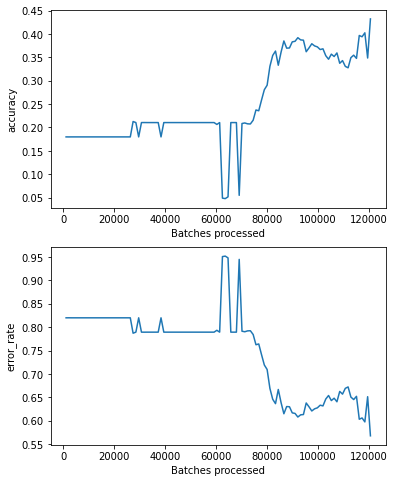

In [61]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()

In [62]:
learner.save(os.path.join(ROOT_PATH, 'results', KOKONOTEST))

In [ ]:
#============================-

In [73]:
from datetime import datetime

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.038580,1.349942,0.406510,0.593490,04:02
1,0.999431,1.298832,0.414520,0.585480,04:23
2,1.026793,1.364797,0.376330,0.623670,03:45
3,1.011238,1.334035,0.399205,0.600795,04:06
4,0.995303,1.280376,0.432974,0.567025,04:19
5,0.998017,1.277942,0.424324,0.575676,04:05
6,1.066208,1.334186,0.404972,0.595028,04:03
7,1.003868,1.306472,0.418237,0.581763,04:18
8,1.053569,1.258031,0.431244,0.568756,04:05
9,0.978157,1.274110,0.435025,0.564975,04:02


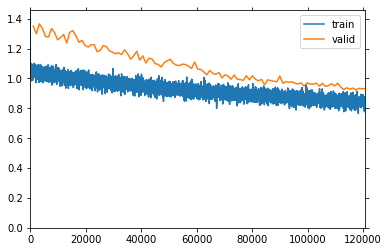

NameError: name 'datetime' is not defined

In [72]:
learner.fit(epochs=110, lr=1e-6)
learner.save(os.path.join(ROOT_PATH, 'results_' + datetime.now().strftime("%y%m%d%H%M")))

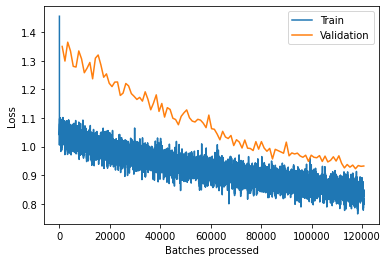

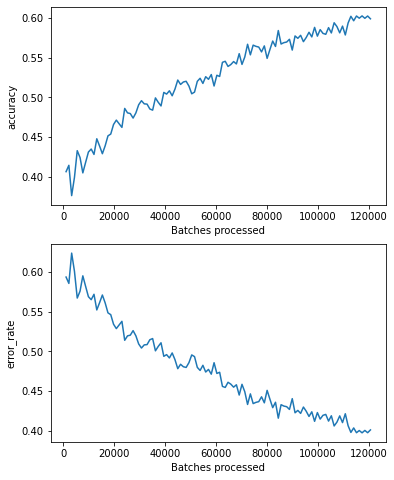

In [75]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()

In [80]:
learner.fit(epochs=110, lr=1e-6)
learner.save(os.path.join(ROOT_PATH, 'results_' + datetime.now().strftime("%y%m%d%H%M")))

epoch,train_loss,valid_loss,accuracy,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 158.00 MiB (GPU 0; 23.70 GiB total capacity; 21.06 GiB already allocated; 154.56 MiB free; 21.92 GiB reserved in total by PyTorch)

In [ ]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()

In [ ]:
learner.fit(epochs=110, lr=1e-6)
learner.save(os.path.join(ROOT_PATH, 'results_' + datetime.now().strftime("%y%m%d%H%M")))

In [ ]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()

In [ ]:
#============================-

In [63]:
learner.show_results()

text,target,prediction
"<s> ĠWhen Ġit Ġ' s Ġnot Ġwall owing Ġin Ġhormonal Ġmel od rama Ġ, Ġ`` ĠReal ĠWomen ĠHave ĠCur ves Ġ'' Ġis Ġa Ġsweet Ġ, Ġhonest Ġ, Ġand Ġenjoyable Ġcomedy - d rama Ġabout Ġa Ġyoung Ġwoman Ġwho Ġwants Ġmany Ġthings Ġin Ġlife Ġ, Ġbut Ġfears Ġshe Ġ' ll Ġbecome Ġher Ġmother Ġbefore Ġshe Ġgets Ġto Ġfulfill Ġher Ġdreams Ġ. </s>",3,4
<s> ĠChristian ĠBale Ġ' s ĠQuinn Ġ- L RB - Ġis Ġ- RR B - Ġa Ġleather Ġclad Ġgrun ge - pir ate Ġwith Ġa Ġha ird o Ġlike ĠGand alf Ġin Ġa Ġwind - tun nel Ġand Ġa Ġsimply Ġastounding Ġcor - bl ime y - lu v - a - du ck Ġcock ney Ġaccent Ġ. Ġ' </s>,2,4
"<s> ĠThe Ġfilm Ġwas Ġproduced Ġby ĠJerry ĠBru ck heimer Ġand Ġdirected Ġby ĠJoel ĠSch um acher Ġ, Ġand Ġreflects Ġthe Ġworst Ġof Ġtheir Ġshallow Ġstyles Ġ: Ġwildly Ġover produced Ġ, Ġinadequ ately Ġmotivated Ġevery Ġstep Ġof Ġthe Ġway Ġand Ġdem ographically Ġtargeted Ġto Ġplease Ġevery Ġone Ġ- L RB - Ġand Ġno Ġone Ġ- RR B - Ġ. </s>",1,1
"<s> Ġworks Ġbecause Ġits Ġfl ab berg asting Ġprincipals Ġ, Ġ14 - year - old ĠRobert ĠMac N augh ton Ġ, Ġ6 - year - old ĠDrew ĠBarry more Ġand Ġ10 - year - old ĠHenry ĠThomas Ġ, Ġconvince Ġus Ġof Ġthe Ġexistence Ġof Ġthe Ġwise Ġ, Ġw iz ened Ġvisitor Ġfrom Ġa Ġfar away Ġplanet Ġ. </s>",2,1
"<s> ĠAngela ĠG he or gh iu Ġas Ġfamous Ġprim a Ġdon na ĠFlor ia ĠTos ca Ġ, ĠRoberto ĠAl agna Ġas Ġher Ġlover ĠMario ĠCav ar ad oss i Ġ, Ġand ĠRug ger o Ġas Ġthe Ġvillain ous Ġ, Ġle cher ous Ġpolice Ġchief ĠSc arp ia Ġ, Ġall Ġsing Ġbeautifully Ġand Ġact Ġadequately Ġ. </s>",3,4


#### Export Learner (model)

In [64]:
# learner.export(model_name)
# !mv ./export.pkl /content/drive/My\ Drive/LAB/kge_sentiment_analysis
# !mv /content/drive/My\ Drive/LAB/kge_sentiment_analysis/export.pkl /content/drive/My\ Drive/LAB/bsz2048_DEM-RoBERTa.pkl

In [65]:
# path = '/content/drive/My Drive/LAB/'
# export_learner = load_learner(path, file = model_name)

In [66]:
# export_learner.predict('This is the worst movie of 2020')

#### Creating prediction

In [67]:
# def get_preds_as_nparray(ds_type) -> np.ndarray:
#     preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
#     sampler = [i for i in databunch.dl(ds_type).sampler]
#     reverse_sampler = np.argsort(sampler)
#     return preds[reverse_sampler, :]

# test_preds = get_preds_as_nparray(DatasetType.Test)

In [68]:
# sample_submission = pd.read_csv(DATA_ROOT / 'sampleSubmission.csv')
# sample_submission['Sentiment'] = np.argmax(test_preds, axis = 1)
# sample_submission.to_csv('prediction.csv', index = False)

In [69]:
# test.head()

In [70]:
# sample_submission.head()

In [71]:
# from IPython.display import HTML

# def create_download_link(title = 'Download CSV file', filename = 'data.csv'):
#     html = '<a href=(filename)->(title)</a>'
#     html = html.format(title=title, filename=filename)
#     return HTML(html)

# create_download_link(filename='prediciton.csv')